# Creación del modelo de clasificación de cancer benigno.

## Datos de las imagenes.

Todas las imagenes han de este conjunto de imagenes de kaggle:
- Enlace: https://www.kaggle.com/datasets/riyaelizashaju/isic-skin-disease-image-dataset-labelled

De este dataset hemos utilizado las carpetas que son consideradas benignas como  queratosis seborreica, dermatofibroma y Melanocytic nevus.

#Instalaciones y las importaciones.

In [1]:
!pip install imblearn==0.0
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install scipy
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import zipfile
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, DenseNet121, InceptionV3, ResNet50, MobileNetV2, VGG19, Xception
from tensorflow.python.client import device_lib
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint
import seaborn as sns
from collections import Counter
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from google.colab import drive
import os
%matplotlib inline

## Extraer las imagenes

Extraemos todas las imagenes de un archivo zip alojado en drive y la descomprimimos en una variable llamada train_dir eso contiene tres carpetas que seran las tres clases de imagenes que hay y todas las imagenes dentro de su respectiva carpeta.

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Ruta del archivo ZIP en Google Drive
ruta_archivo_zip = '/content/drive/MyDrive/dataset/clasificador_de_benignos.zip'

# Ruta donde deseas extraer los archivos
ruta_destino = '/content/extracted/'

# Descomprime el contenido del ZIP
with zipfile.ZipFile(ruta_archivo_zip, 'r') as zip_ref:
    zip_ref.extractall(ruta_destino)

# Lista los archivos extraídos
archivos_extraidos = os.listdir(ruta_destino)
print(f'Archivos extraídos: {archivos_extraidos}')

# Ruta de la carpeta que contiene las imágenes
train_dir = os.path.join(ruta_destino,'clasificador_de_benignos')


# Verifica la existencia de la carpeta antes de listar los archivos
if os.path.exists(train_dir):
    archivos_en_carpeta = os.listdir(train_dir)
    print(f'Archivos en la carpeta: {archivos_en_carpeta}')
else:
    print(f'La carpeta {train_dir} no existe.')


# Lista de nombres de archivos en la carpeta
skin = os.listdir(train_dir)

Archivos extraídos: ['clasificador_de_benignos']
Archivos en la carpeta: ['Dermatofibroma', 'queratosis seborreica', 'Melanocytic nevus']


## Muestras de los datos.

In [ ]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for s in skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


no. of images
queratosis seborreica           2624
Melanocytic nevus               3676
Dermatofibroma                   239

<Axes: title={'center': 'data distribution '}, xlabel='Type of skin cancer', ylabel='Number of image'>

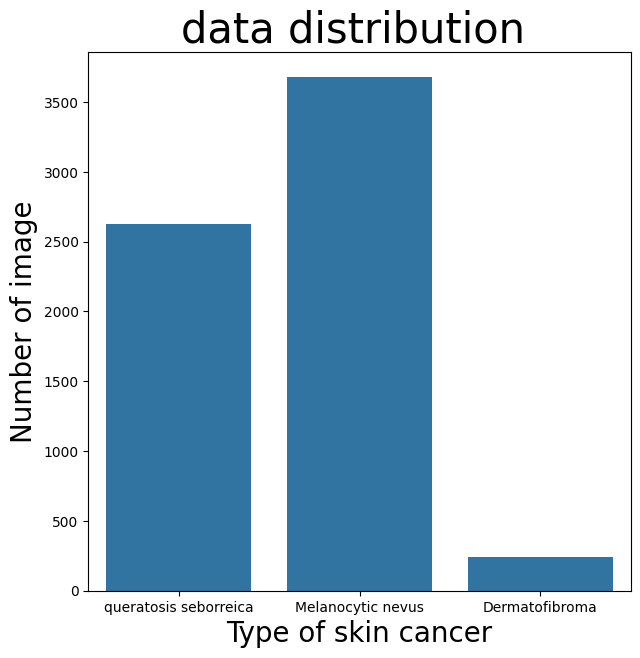

In [ ]:
plt.figure(figsize=(7,7))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of skin cancer',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

Podemos ver que queratosis seborreica y melanocytic nevus si estan equilibradas pero dermatofibroma tiene muy pocas imagenes.

## Mostrar imagenes de muestra:

In [5]:
# Function to show image
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)


### Dermatofibroma

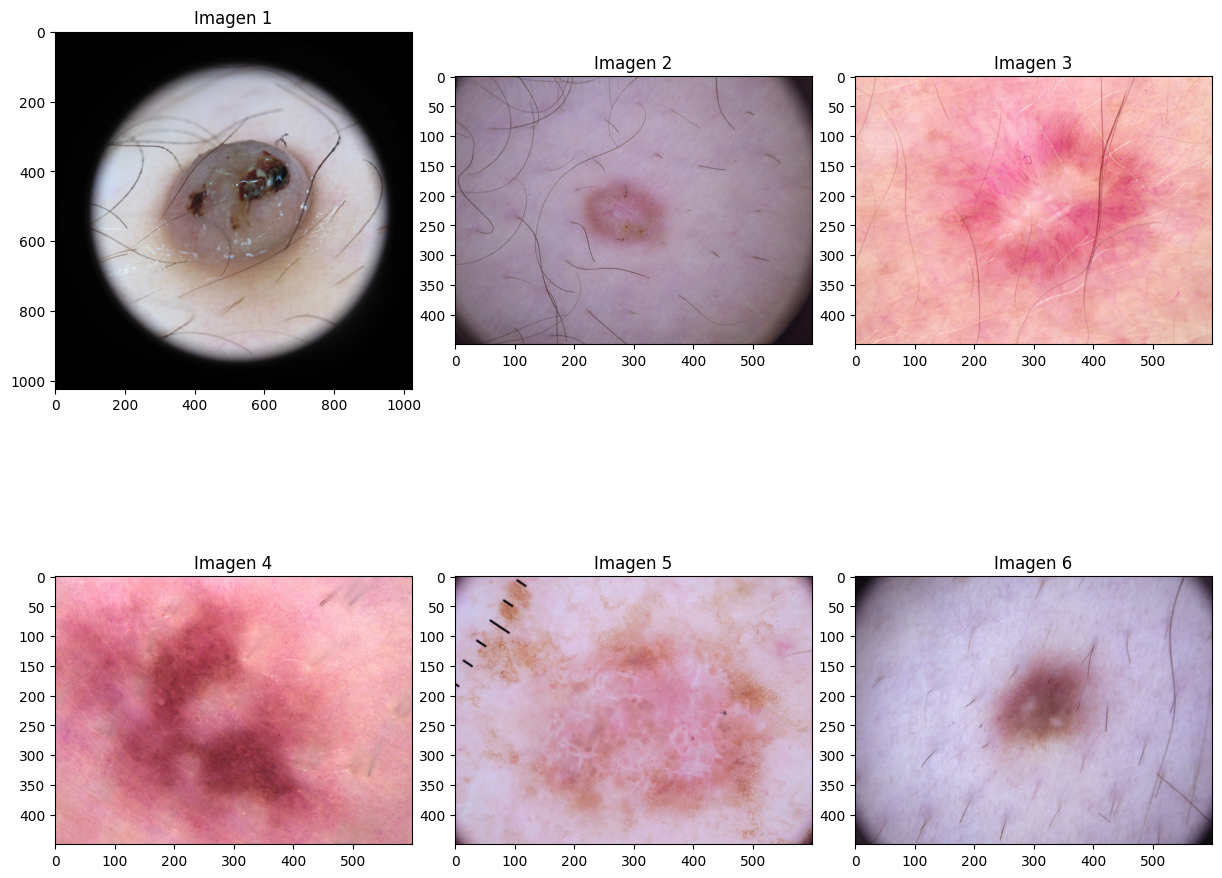

In [6]:
# Directorio que contiene las imágenes
basal_cell_carcinoma_dir = os.path.join(train_dir, "Dermatofibroma")

# Muestra 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

# Iterar sobre las primeras 6 imágenes del directorio
for i in range(6):
    image_files = [file for file in os.listdir(basal_cell_carcinoma_dir) if file.endswith('.jpg')]
    if i < len(image_files):
        image_path = os.path.join(basal_cell_carcinoma_dir, image_files[i])
        image = Image.open(image_path)
        axs[i//3, i%3].imshow(image)
        axs[i//3, i%3].set_title(f'Imagen {i+1}')
    else:
        axs[i//3, i%3].axis('off')  # No mostrar ejes si no hay imagen para mostrar

plt.show()

### Melanocytic nevus

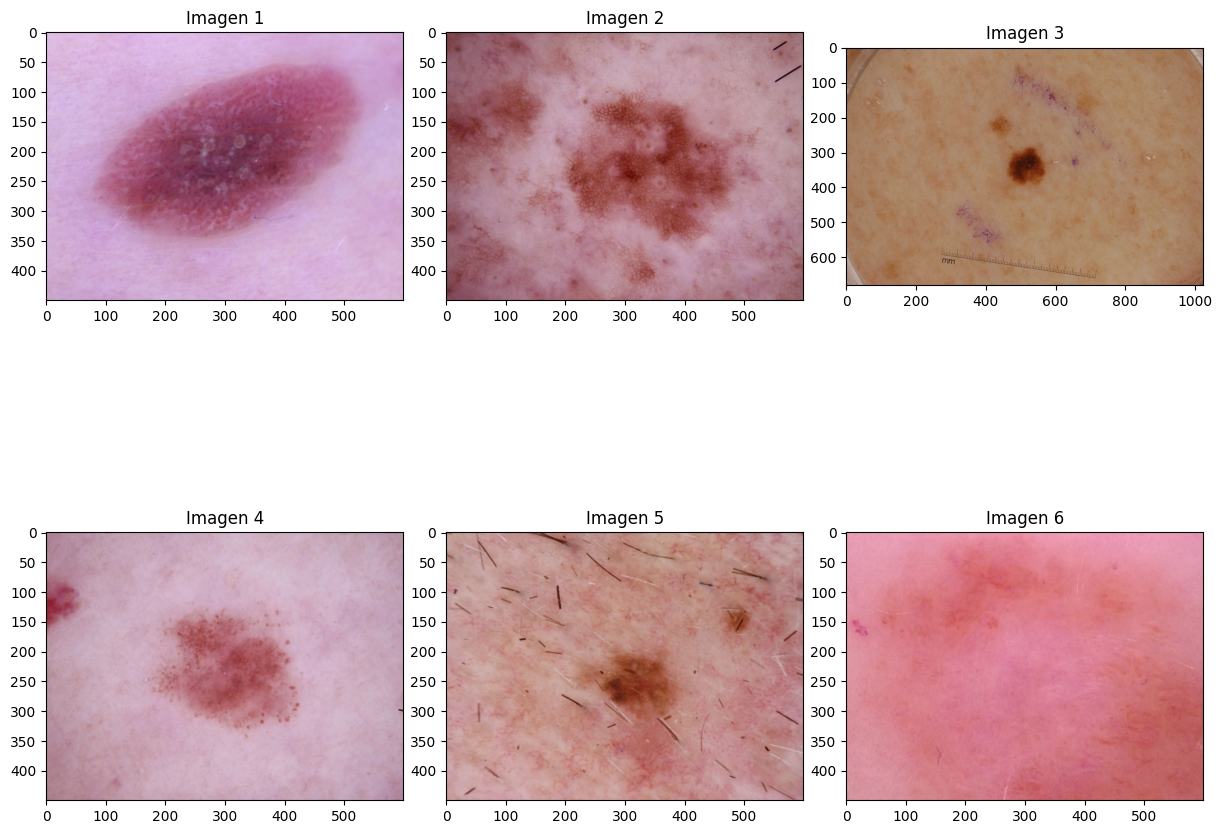

In [7]:
# Directorio que contiene las imágenes
basal_cell_carcinoma_dir = os.path.join(train_dir, "Melanocytic nevus")

# Muestra 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

# Iterar sobre las primeras 6 imágenes del directorio
for i in range(6):
    image_files = [file for file in os.listdir(basal_cell_carcinoma_dir) if file.endswith('.jpg')]
    if i < len(image_files):
        image_path = os.path.join(basal_cell_carcinoma_dir, image_files[i])
        image = Image.open(image_path)
        axs[i//3, i%3].imshow(image)
        axs[i//3, i%3].set_title(f'Imagen {i+1}')
    else:
        axs[i//3, i%3].axis('off')  # No mostrar ejes si no hay imagen para mostrar

plt.show()

### Queratosis seborreica

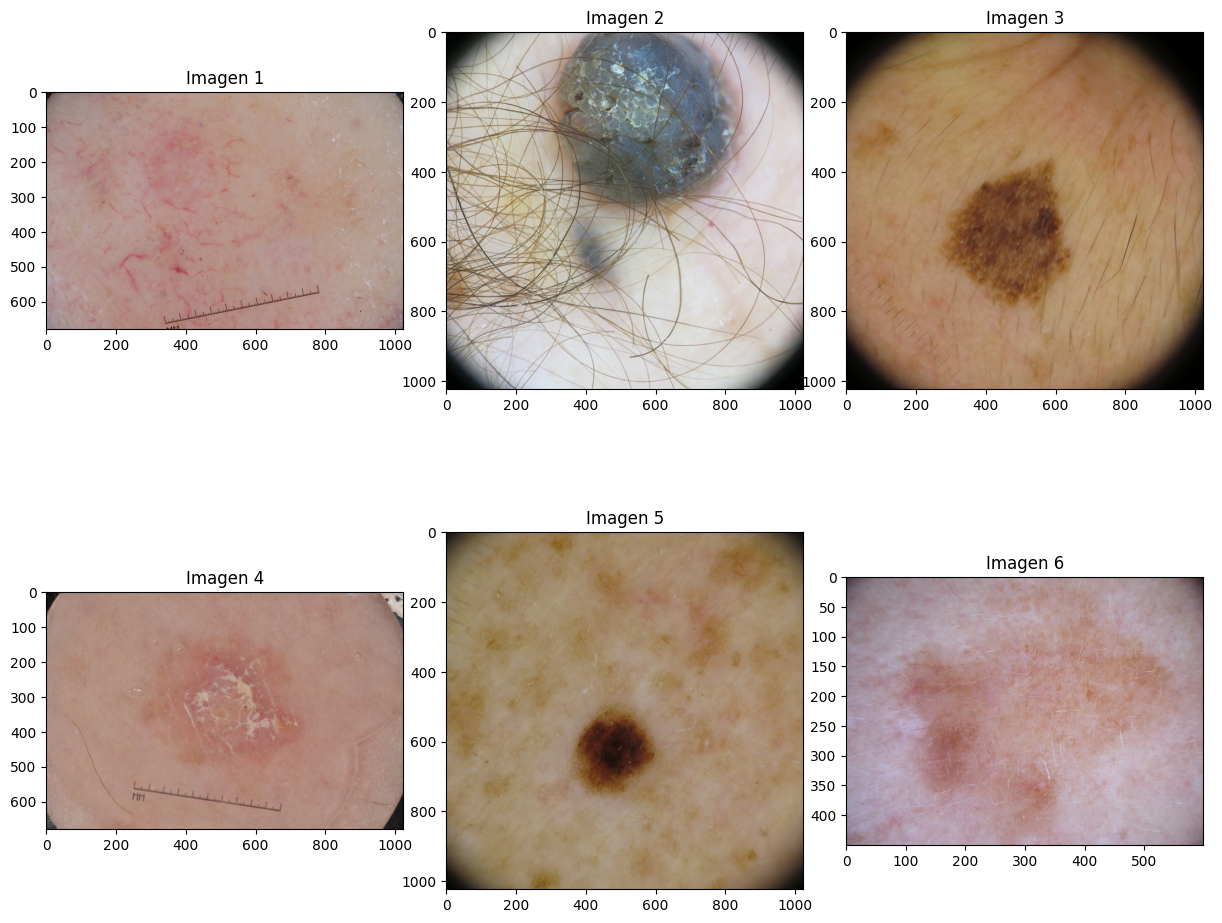

In [8]:
# Directorio que contiene las imágenes
basal_cell_carcinoma_dir = os.path.join(train_dir, "queratosis seborreica")

# Muestra 6 imágenes
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
fig.tight_layout(pad=0)

# Iterar sobre las primeras 6 imágenes del directorio
for i in range(6):
    image_files = [file for file in os.listdir(basal_cell_carcinoma_dir) if file.endswith('.jpg')]
    if i < len(image_files):
        image_path = os.path.join(basal_cell_carcinoma_dir, image_files[i])
        image = Image.open(image_path)
        axs[i//3, i%3].imshow(image)
        axs[i//3, i%3].set_title(f'Imagen {i+1}')
    else:
        axs[i//3, i%3].axis('off')  # No mostrar ejes si no hay imagen para mostrar

plt.show()

## Redimensionamiento de imagenes y transformacion

En este bloque de codigo estamos redimensionando las imagenes a un tamaño de 150 x 150, despues concatenamos todos los datos en arrays con las tres categorias y sus etiquetas.

In [ ]:
def redimensionar_imagen(ruta, nuevo_tamano):
    imagen = Image.open(ruta)
    imagen_redimensionada = imagen.resize(nuevo_tamano)
    arreglo_pixeles_redimensionado = np.array(imagen_redimensionada)
    return arreglo_pixeles_redimensionado

# Definir el nuevo tamaño deseado
tamano=150
nuevo_tamano = (tamano, tamano)


# Redimensionar las imágenes de entrenamiento Basal cell carcinoma
datos_train_bcb_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'Dermatofibroma', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'Dermatofibroma'))]
# Redimensionar las imágenes de entrenamiento Melanoma
datos_train_m_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'Melanocytic nevus', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'Melanocytic nevus'))]
# Redimensionar las imágenes de entrenamiento Squamous cell carcinoma
datos_train_scc_redimensionados = [redimensionar_imagen(os.path.join(train_dir, 'queratosis seborreica', nombre_imagen), nuevo_tamano) for nombre_imagen in os.listdir(os.path.join(train_dir, 'queratosis seborreica'))]

# Asegurarse de que todas las imágenes tengan el mismo tamaño
datos_train_bcb_redimensionados = np.array([img for img in datos_train_bcb_redimensionados if img.shape == (tamano, tamano, 3)])
datos_train_m_redimensionados = np.array([img for img in datos_train_m_redimensionados if img.shape == (tamano, tamano, 3)])
datos_train_scc_redimensionados = np.array([img for img in datos_train_scc_redimensionados if img.shape == (tamano, tamano, 3)])

# Concatenar los datos de ambas clases
datos_train_redimensionados = np.concatenate([
                                              datos_train_bcb_redimensionados,
                                              datos_train_m_redimensionados,
                                              datos_train_scc_redimensionados], axis=0)

# Crear etiquetas correspondientes para cada clase
etiquetas_train_bcb = np.zeros(len(datos_train_bcb_redimensionados))
etiquetas_train_m = np.ones(len(datos_train_m_redimensionados), )
etiquetas_train_scc = np.full(len(datos_train_scc_redimensionados), 2)

# Concatenar las etiquetas de todas las clases
etiquetas_train_redimensionadas = np.concatenate([
                                                  etiquetas_train_bcb,
                                                  etiquetas_train_m,
                                                  etiquetas_train_scc], axis=0)



Aqui estamos dividiendo los datos para tener los datos de entrenamiento y test y sus etiquetas correspondientes, tambien normalizamos los pixeles diviendo entre 255 y convertimos la etiquetas a un formato one-hot.

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(datos_train_redimensionados, etiquetas_train_redimensionadas, test_size=0.2, random_state=42)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

## Preparacion para los modelos

En el siguiente bloque de codigo lo que tenemos es una clase CustomLearningRateScheduler que lo que hace es a la hora del callback llama a esta clase para ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento de un modelo, la metrica que se esta monitoreando es el Val_accuracy con una paciencia de 1 epoca. Eso significa que si el val_accuracy de una epoca a otra a desminuido se ejecuta la clase disminuyendo el learning rate dividiendolo entre /2 eso significa que si antes teniamos 0.0001 ahora tendriamos 0.0005.
Tambien tenemos un checkpoint que va guardando el modelo cada vez que mejora el val_accuracy porque muchas veces pasa que durante el entrenamiento ha habido alguna epoca mejor que la ultima donde ha terminado el modelo su entrenamiento.

Por ultimo se esta haciendo un ImageDataGenerator que se encarga de realizar aumento de datos y preprocesamiento para conjuntos de entrenamiento y prueba en un problema de clasificación de imágenes. Esto es especialmente útil para mejorar la capacidad de generalización del modelo al exponerlo a variaciones en los datos durante el entrenamiento. El aumento de datos ayuda a prevenir el sobreajuste al proporcionar más variabilidad en el conjunto de entrenamiento.

In [ ]:
class CustomLearningRateScheduler(Callback):
    def __init__(self, factor=0.5, patience=1, min_lr=1e-7):
        super(CustomLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.current_lr = None

    def on_epoch_begin(self, epoch, logs=None):
        if self.current_lr is None:
            self.current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy', 0)

        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.wait = 0
            # Guardar el modelo cuando la precisión en el conjunto de validación mejora
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.current_lr * self.factor, self.min_lr)
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                self.current_lr = new_lr  # Actualizar el valor actual de la tasa de aprendizaje
                print(f'Reverting learning rate to {new_lr}')
                self.wait = 0


# Aumento de datos para el conjunto de entrenamiento y prueba
datagen_train = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.35,
    height_shift_range=0.35,
    shear_range=0.35,
    zoom_range=0.35,
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen_test = ImageDataGenerator()

datagen_train.fit(X_train)
datagen_test.fit(X_test)


# Generador de imágenes aumentadas para el conjunto de entrenamiento
train_generator = datagen_train.flow(X_train, y_train_one_hot, batch_size=32)

# Generador de imágenes para el conjunto de prueba
test_generator = datagen_test.flow(X_test, y_test_one_hot, batch_size=32)



## Modelo

Aqui tenemos un modelo que  hemos utilizado Xception.

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(tamano, tamano, 3), pooling='max')

# Crear el callback CustomLearningRateScheduler
custom_lr_scheduler = CustomLearningRateScheduler(factor=0.5, patience=2, min_lr=1e-12)

# Callback para guardar el modelo con la mejor precisión en el conjunto de validación
model_checkpoint = ModelCheckpoint('best_model_checkpoint7.h5', save_best_only=True, monitor='val_accuracy', mode='max')

# Agregar capas personalizadas
x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

# Crear el modelo
model7 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers[-10:]:
    layer.trainable = True


# Compilar el modelo con el optimizador Adam y el callback ReduceLROnPlateau
model7.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo utilizando el generador de datos aumentados para el conjunto de entrenamiento
history=model7.fit(train_generator, validation_data=test_generator, epochs=20,callbacks=[custom_lr_scheduler, model_checkpoint])

Hemos terminado con un 93,89% de precisión en los datos de entrenamiento.

## Importando el mejor modelo del checkpoint.

In [ ]:
# Ruta al archivo .h5
ruta_archivo = '/content/best_model_checkpoint7.h5'

# Carga el modelo
modelo4 = load_model(ruta_archivo)


## Grafico del modelo

Figure(1200x400)


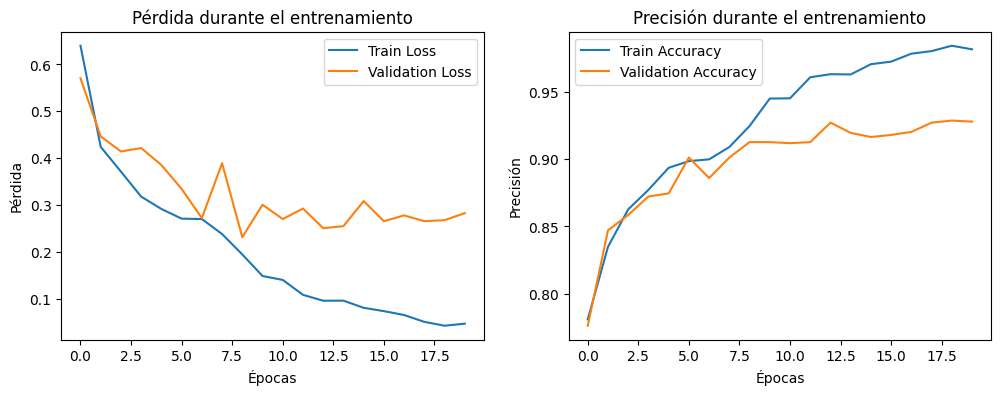

In [ ]:
# Visualizar gráficos de pérdida y precisión
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de pérdida
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Pérdida durante el entrenamiento')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Pérdida')
ax1.legend()

# Gráfico de precisión
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Precisión durante el entrenamiento')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Precisión')
ax2.legend()

print(fig)

## Comprobación del modelo.

### Resultados del modelo.

In [ ]:

# Hacer predicciones con el modelo
y_pred = modelo4.predict(X_test)

# Obtener las clases predichas (índice de la clase con probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Calcular el número de aciertos y fallos
correct_predictions = np.sum(predicted_labels == y_test)
incorrect_predictions = len(y_test) - correct_predictions

# Calcular la precisión
accuracy = correct_predictions / len(y_test)

# Imprimir resultados
print(f'Número de aciertos: {correct_predictions}')
print(f'Número de fallos: {incorrect_predictions}')
print(f'Accuracy: {accuracy}')

# Calcular métricas
y_test_classes = y_test.flatten()

# Calcular métricas

conf_matrix = confusion_matrix(y_test_classes, predicted_labels)
class_report = classification_report(y_test_classes, predicted_labels)

# Imprimir métricas

print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Podemos ver que el resultado final ha sido de 93,33% que esta bastante bien y vemos el numero de fallos y aciertos que ha tenido el modelo con la clase de test. Podemos ver que  tanto en la clase de queratosis y dematofibroma tenemos un 90% de precisión frente al 96% de melatocytic nevus.

### Imagenes bien clasificadas.

1/1 [==============================] - 0s 29ms/step


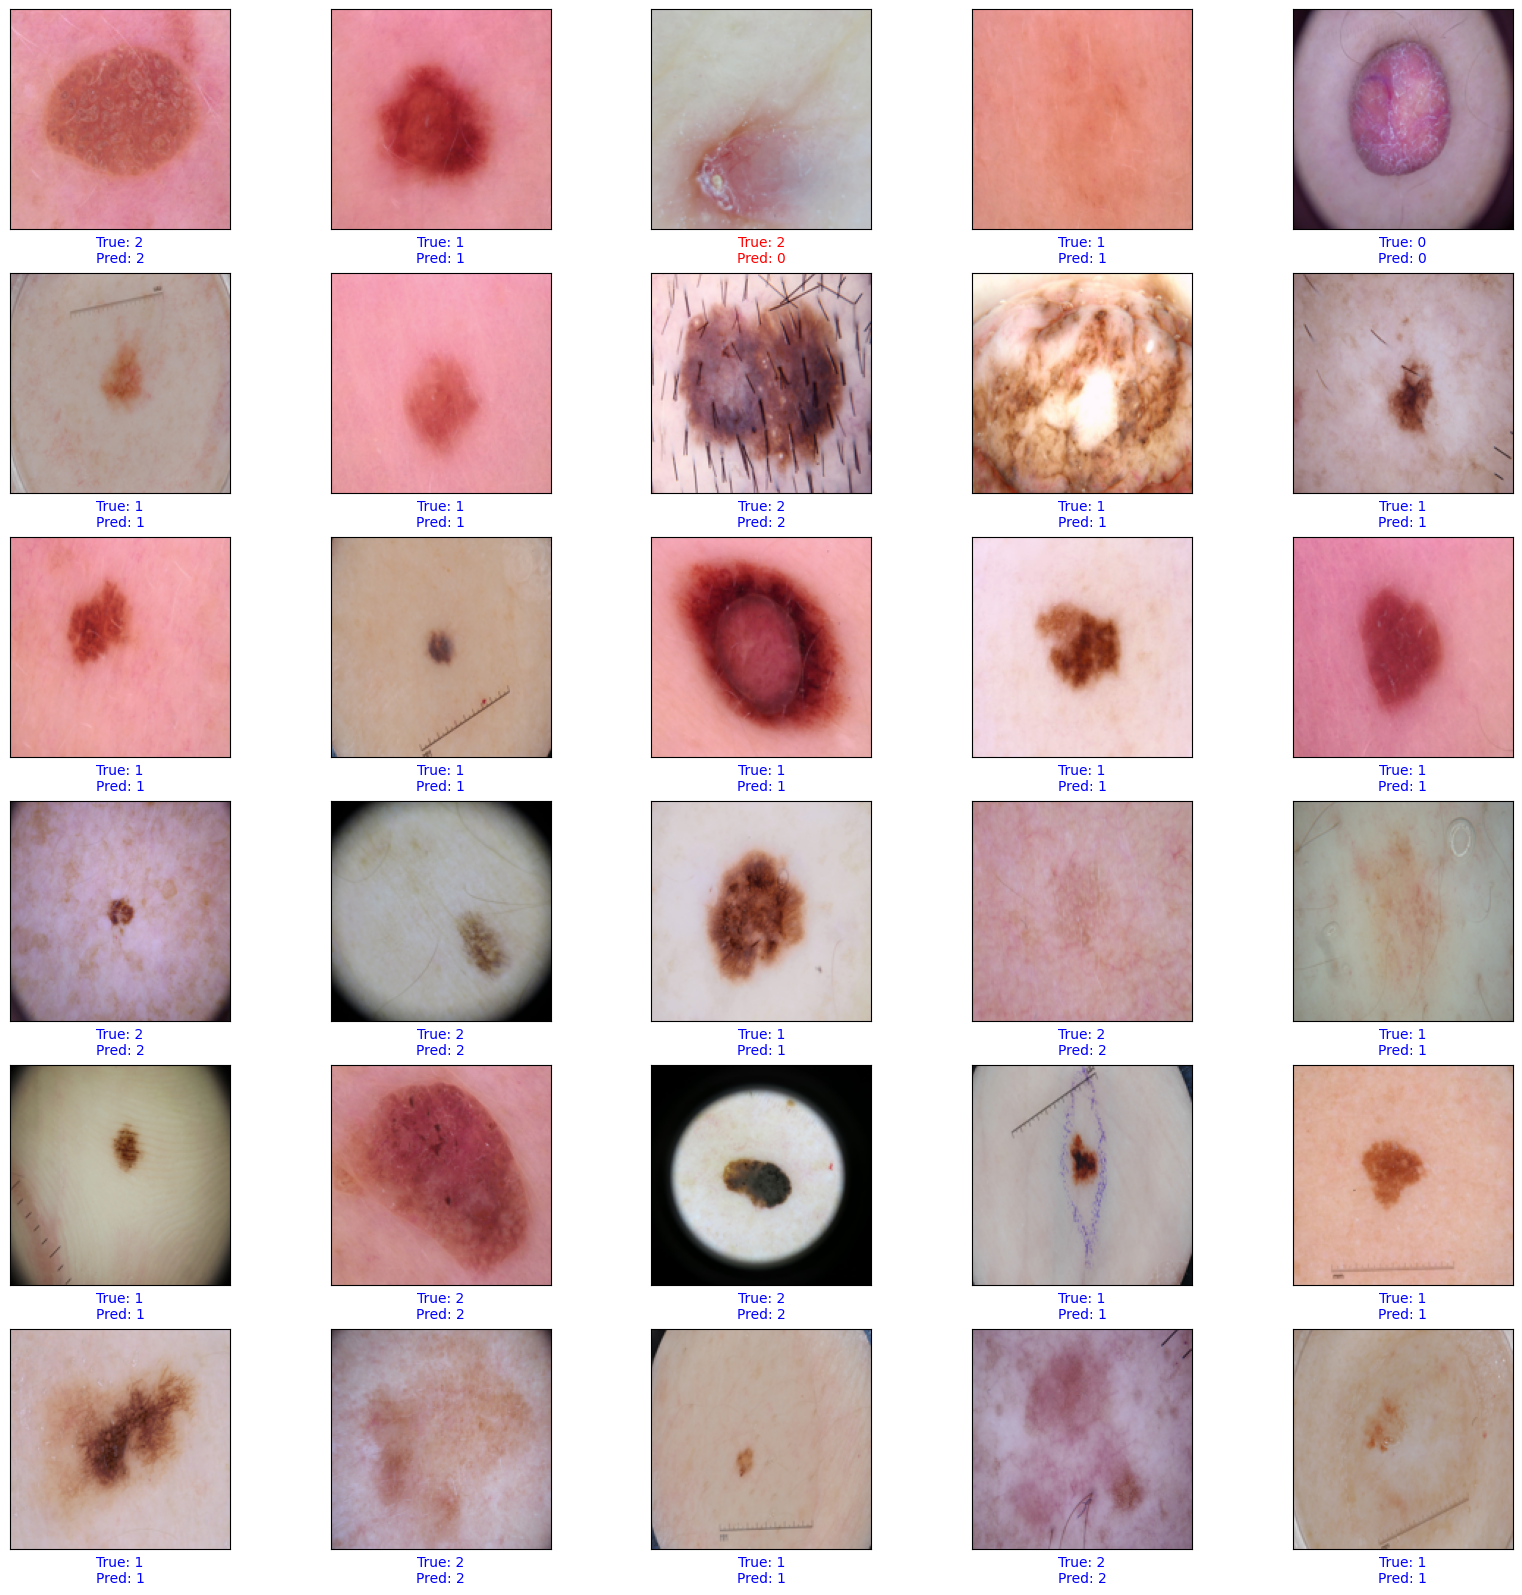

In [ ]:
# Obtener el lote de imágenes y etiquetas del generador de prueba
images_batch, labels_batch = next(test_generator)

# Obtener las predicciones del modelo para el lote actual
y_pred = modelo4.predict(images_batch)

# Obtener las etiquetas predichas (índice de la clase con la probabilidad más alta)
predicted_labels = np.argmax(y_pred, axis=1)

# Obtener las etiquetas reales (índice de la clase con el valor más alto en labels_batch)
true_labels = np.argmax(labels_batch, axis=1)

# Muestra solo las imágenes bien clasificadas
plt.figure(figsize=(20, 20))
for i in range(30):
    plt.subplot(6, 5, i + 1)  # Ajusta el número de filas y columnas según sea necesario
    cmap_image = "binary" if predicted_labels[i] == true_labels[i] else "Oranges"
    plt.imshow(images_batch[i], cmap=cmap_image)
    plt.xticks([])
    plt.yticks([])
    c = "blue" if predicted_labels[i] == true_labels[i] else "red"
    plt.xlabel(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}", color=c)

plt.show()


### Imagenes mal clasificadas

<ipython-input-18-bb73e0683cec>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = modelo4.predict_generator(test_generator)


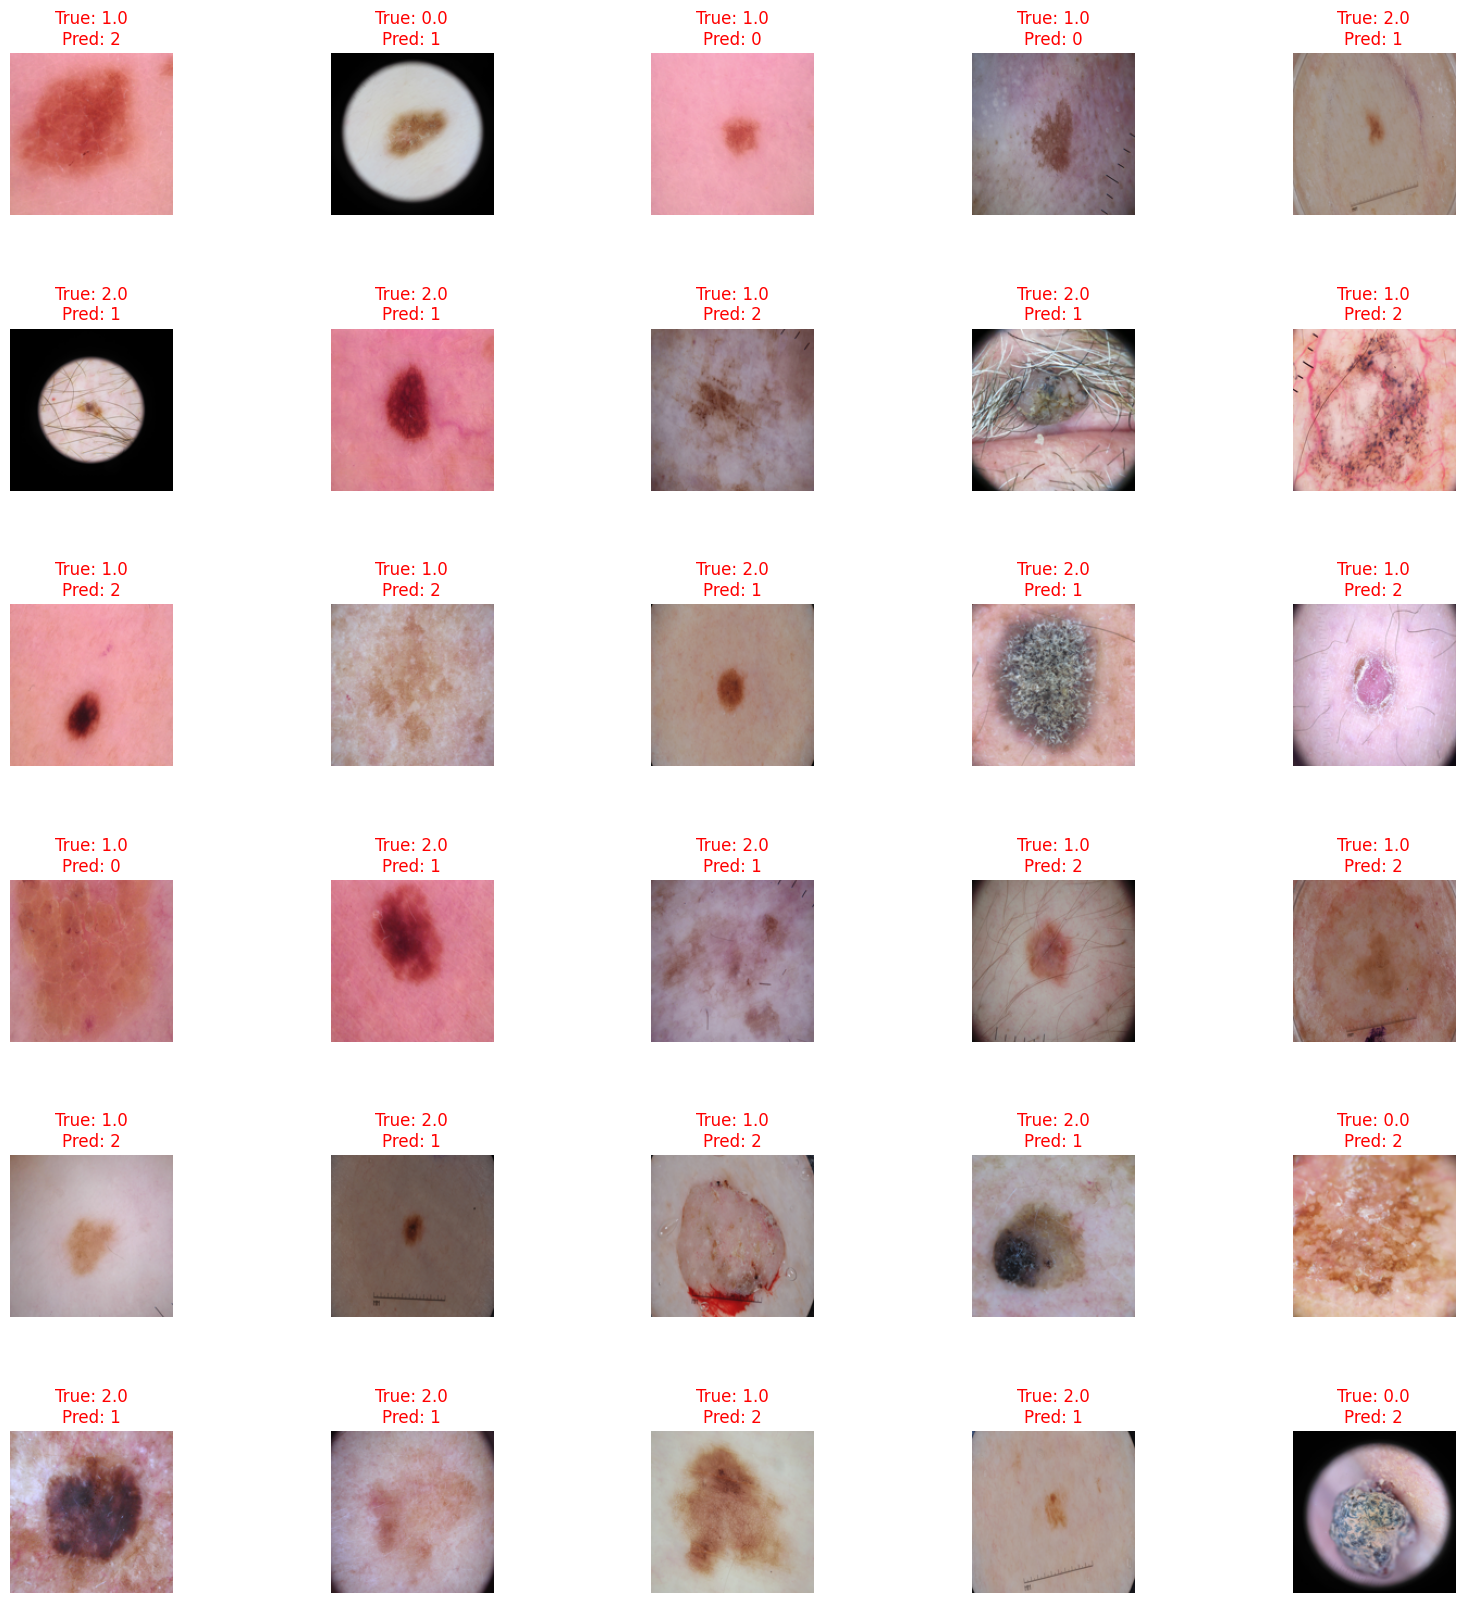

In [ ]:
# Obtener las etiquetas reales del generador
y_true = y_test

# Obtener las predicciones del modelo
predictions = modelo4.predict_generator(test_generator)

# Obtener las etiquetas predichas
y_pred = predictions.argmax(axis=1)

# Obtener índices de imágenes mal clasificadas
indices_mal_clasificadas = np.where(y_true != y_pred)[0]

# Número total de imágenes mal clasificadas
total_imagenes = len(indices_mal_clasificadas)

# Establecer el número máximo de imágenes a mostrar (30 o el total de imágenes mal clasificadas, el que sea menor)
max_imagenes_mostrar = min(30, total_imagenes)

# Configurar la visualización de imágenes mal clasificadas
filas = 6
columnas = 5
plt.figure(figsize=(20, 20))

for i in range(max_imagenes_mostrar):
    images_batch, labels_batch = test_generator.next()

    imagen_mal_clasificada = images_batch[0]

    plt.subplot(filas, columnas, i + 1)
    plt.imshow(imagen_mal_clasificada)
    plt.title(f"True: {y_true[indices_mal_clasificadas[i]]}\nPred: {y_pred[indices_mal_clasificadas[i]]}", color="red")
    plt.axis('off')

plt.subplots_adjust(hspace=0.7)
plt.show()


## Exportando el modelo.

Exportamos el modelo a drive en un formato .tflite ya que este formato pesa menos MG, ya que a la hora de subirlo al github solo se pueden subir archivos que pesen menos de 100MG

In [ ]:
# Convertir el modelo en un modelo compatible con TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(modelo4)
tflite_model = converter.convert()

# Guardar el modelo TFLite en un archivo
with open('/content/drive/MyDrive/dataset/clasificador_cancer_benignos.tflite', 'wb') as f:
    f.write(tflite_model)

## Conclusion.

Hemos sacado un resultado de 93,33% lo cual esta cerca de nuestro objetivo de un 95% pero actualmente estamos satisfecho de este resultado por la falta de imagenes para el entrenamiento.